In [1]:
# Use CPU only
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import h5py

import cv2
import sys
import itertools


np.random.seed(1337)
from tensorflow import set_random_seed
set_random_seed(1337)

from utils import *


Using TensorFlow backend.


In [2]:
project_dir = '/home/rabreu/projeto_multimodal/'
data_dir = project_dir+'data/'

audioset_indices_csv = project_dir+'segments/subset_class_labels_indices.csv'

## pegando dataset desbalanceado, que eu balanceei para 600 ocorrências para cada classe
audioset_train_csv = project_dir+'segments/2000max_subset_unbalanced_train_segments.csv'
train_sub_dir = '2000unbalanced_train/video'

audioset_eval_csv = project_dir+'segments/subset_eval_segments.csv'
eval_sub_dir = 'eval/video'

### Carregando dados

In [3]:
# Load up numpy arrays to save time if they have already been procesed.

save_dir = data_dir+train_sub_dir+"/2000features/"
feature_file = os.path.join(save_dir+'_x.npy')
labels_file = os.path.join(save_dir+'_y.npy')
train_x = np.load(feature_file)
train_y = np.load(labels_file)
print(train_x.shape)


save_dir = data_dir+eval_sub_dir+"/features/"
feature_file = os.path.join(save_dir+'_x.npy')
labels_file = os.path.join(save_dir+'_y.npy')
eval_x = np.load(feature_file)
eval_y = np.load(labels_file)
print(eval_x.shape)

(10950, 32, 32, 32, 3)
(532, 32, 32, 32, 3)


In [4]:
fps_trimmed = 3 # get four frames each second
max_frames = 32 # cut the video past this treshold
frame_size = 32 # 32x32 pixels

In [6]:
n_dim = np.empty((max_frames,frame_size,frame_size,3)).shape  # TODO: Fazer o slicing do train_x corretamente. 
n_classes = train_y.shape[1]

print "Feature Dimension:", n_dim, "Classes:", n_classes

Feature Dimension: (32, 32, 32, 3) Classes: 7


In [7]:
## Mapeando valores para o espaço entre 0 e 1... será que dá diferença?

train_x = train_x.astype('float32')
eval_x = eval_x.astype('float32')
train_x  /= 255
eval_x /= 255

### Time distributed

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras.layers import Input
from keras.models import Model


from keras.layers.merge import concatenate


from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM

from keras.optimizers import SGD


import keras.backend as K

print(n_dim)
# o modelo original não tinha padding no maxpooling. 
#Tive que inserir para comportar nosso tamanho de imagem que é de 32x32 atualmente

video_input  = Input(shape=(n_dim),name='video_input')

#model.add(BatchNormalization(epsilon=1e-06,input_shape=n_dim, axis = 1, momentum=0.9, weights=None)) # Normalizar no input vale a pena? talvez seja algo a testar.


video = TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2),
    activation='relu', padding='same',data_format="channels_last"), input_shape=n_dim)(video_input)
video = TimeDistributed(BatchNormalization())(video)
video = TimeDistributed(Conv2D(32, (3,3),
    padding='same', activation='relu'))(video)
video = TimeDistributed(BatchNormalization())(video)
video = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)))(video)
video = TimeDistributed(Dropout(0.5))(video)



video = TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu'))(video)
video = TimeDistributed(BatchNormalization())(video)
video = TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu'))(video)
video = TimeDistributed(BatchNormalization())(video)
video = TimeDistributed(MaxPooling2D((2, 2),padding="same", strides=(2, 2)))(video)
#model.add(Dropout(0.5))



video = TimeDistributed(Conv2D(128, (3,3),
    padding='same', activation='relu',kernel_initializer='uniform'))(video)
video = TimeDistributed(BatchNormalization())(video)
video = TimeDistributed(Conv2D(128, (3,3),
    padding='same', activation='relu'))(video)
video = TimeDistributed(BatchNormalization())(video)
video = TimeDistributed(MaxPooling2D((2, 2),padding="same", strides=(2, 2)))(video)


#model.add(TimeDistributed(Conv2D(256, (3,3),
#    padding='same', activation='relu')))
#model.add(TimeDistributed(Conv2D(256, (3,3),
#    padding='same', activation='relu')))
#model.add(TimeDistributed(MaxPooling2D((2, 2),padding="same", strides=(2, 2),data_format="channels_last")))

#model.add(TimeDistributed(BatchNormalization()))

#model.add(TimeDistributed(Conv2D(512, (3,3),
#    padding='same', activation='relu')))
#model.add(TimeDistributed(Conv2D(512, (3,3),
#    padding='same', activation='relu')))
#model.add(TimeDistributed(MaxPooling2D((2, 2),padding="same", strides=(2, 2))))

video = TimeDistributed(Flatten())(video)

video =  LSTM(256, return_sequences=False)(video)
video =  Dropout(0.5)(video)
video =  Dense(1000, activation='relu')(video)


## TESTE: SERÁ QUE A CAUSA DA MELHORA SÃO OS LAYERS ADICIONAIS?
video = concatenate([video, video])
video = Dense(500, activation='relu')(video)
video = Dropout(0.5)(video)
video = Dense(500, activation='relu')(video)


main_output = Dense(n_classes, activation='sigmoid',name='main_output')(video)
model = Model(inputs=[video_input], outputs=main_output)

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])


(32, 32, 32, 3)


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video_input (InputLayer)        (None, 32, 32, 32, 3 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 32, 16, 16, 3 896         video_input[0][0]                
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 32, 16, 16, 3 128         time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 32, 16, 16, 3 9248        time_distributed_2[0][0]         
__________________________________________________________________________________________________
time_distr

In [9]:
metrics = custom_metrics()
hist = model.fit(x = train_x,
                 y = train_y,
                 validation_data=(eval_x,eval_y),
                 batch_size=32,
                 epochs = 40,
                 callbacks=[metrics])

Train on 10950 samples, validate on 532 samples
Epoch 1/40
10950/10950 [==============================] - 31s 3ms/step - loss: 0.4308 - binary_accuracy: 0.8287 - val_loss: 0.4897 - val_binary_accuracy: 0.8182
Epoch 2/40
10950/10950 [==============================] - 29s 3ms/step - loss: 0.4049 - binary_accuracy: 0.8328 - val_loss: 0.4853 - val_binary_accuracy: 0.7873
Epoch 3/40
10950/10950 [==============================] - 29s 3ms/step - loss: 0.3952 - binary_accuracy: 0.8350 - val_loss: 0.4239 - val_binary_accuracy: 0.8155
Epoch 4/40
10950/10950 [==============================] - 29s 3ms/step - loss: 0.3869 - binary_accuracy: 0.8382 - val_loss: 0.4196 - val_binary_accuracy: 0.8123
Epoch 5/40
10950/10950 [==============================] - 29s 3ms/step - loss: 0.3805 - binary_accuracy: 0.8413 - val_loss: 0.4313 - val_binary_accuracy: 0.8010
Epoch 6/40
10950/10950 [==============================] - 29s 3ms/step - loss: 0.3738 - binary_accuracy: 0.8426 - val_loss: 0.4442 - val_binary_acc

History keys: ['loss', 'val_binary_accuracy', 'val_loss', 'binary_accuracy']


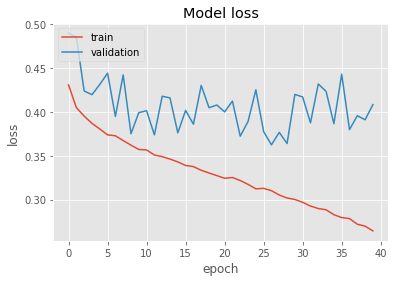

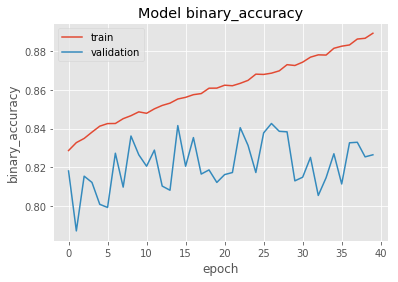

In [10]:
plot_history(hist)

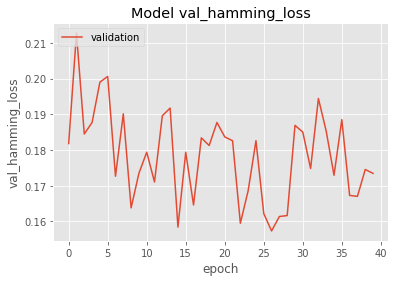

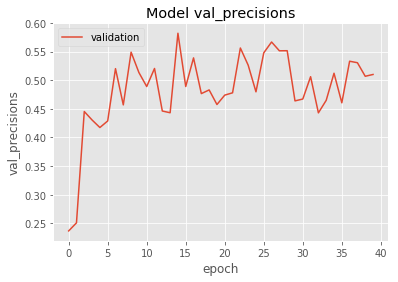

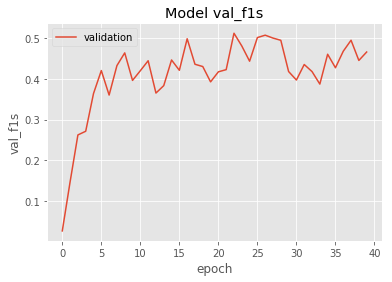

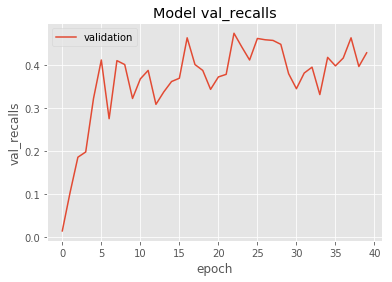

In [11]:
plot_metrics(metrics)

In [12]:
predictions = model.predict(eval_x)
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0

from sklearn.metrics import hamming_loss
print("Hamming Loss:",hamming_loss(eval_y,predictions))

# a diferença entre o ground truth e predições será toda 0 quando os dois forem iguais
## Então buscamos desses não dão tudo 0 e tiramos o inverso disso
predicted_diference = eval_y-predictions
correcly_predicted = (np.where(~(predicted_diference).any(axis=1))[0])
print("Total of correcly predicted:",correcly_predicted.shape[0])
print("Accuracy of correclty predicted:", float(correcly_predicted.shape[0])/eval_y.shape[0])

('Hamming Loss:', 0.17346938775510204)
('Total of correcly predicted:', 160)
('Accuracy of correclty predicted:', 0.3007518796992481)


## Acertos e erros por label
Tipo alguns que acertaram quase todos ou todos

In [13]:
labels = ["Wind","Thunder","Rain","Ocean","Fire","Explosion","Gunshot, gunfire"]
multilabel_confusion_matrix(eval_y,predictions,n_classes)

Multilabel Confusion Matrix
  TP,   FP,     TN,     FN, 
0 69	39	320	104
1 14	12	467	39
2 51	84	356	41
3 45	67	403	17
4 26	15	457	34
5 24	34	443	31
6 53	20	350	109
Σ 282	271	2796	375

F1 Score: 0.466116
Recall: 0.429224
Precision: 0.509946
Hamming Loss: 0.173469


In [14]:
model.save('modelos_salvos/2000video_concat_cnn.h5') 
np.save('modelos_salvos/fusioned_video_history.npy', hist.history)